In [2]:
import tensorflow as tf

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("AMD Stock Price History.csv")

In [4]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/19/2024,118.88,122.16,123.38,118.45,46.16M,-2.08%
1,12/18/2024,121.41,125.43,127.75,120.43,49.72M,-2.89%
2,12/17/2024,125.02,124.45,127.08,123.15,43.31M,-1.32%
3,12/16/2024,126.69,126.01,127.76,123.12,42.09M,-0.17%
4,12/13/2024,126.91,131.30,131.30,124.77,67.54M,-2.83%


### 1 Preprocess data


In [5]:
def convert_volume(vol):
    if vol.endswith('M'):
        return float(vol[:-1]) * 1e6  # Convert millions to numerical
    elif vol.endswith('K'):
        return float(vol[:-1]) * 1e3  # Convert thousands to numerical
    elif vol.endswith('B'):
        return float(vol[:-1]) * 1e9  # Convert billions to numerical
    return float(vol)

# Convert "Change %" column to float percentages
df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float) / 100

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")

In [7]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-12-19,118.88,122.16,123.38,118.45,46160000.0,-0.0208
1,2024-12-18,121.41,125.43,127.75,120.43,49720000.0,-0.0289
2,2024-12-17,125.02,124.45,127.08,123.15,43310000.0,-0.0132
3,2024-12-16,126.69,126.01,127.76,123.12,42090000.0,-0.0017
4,2024-12-13,126.91,131.30,131.30,124.77,67540000.0,-0.0283


### 2 Prep training data


In [8]:
series = df['Price'].values.reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2]) # on first half of series, don't want to include test data in training pipelines
series = scaler.transform(series).flatten()
series.shape

# Splitting data by half is just a quick hack
# If have a specific window to track, need to calculate the exact split position for an appropriate train-test split

(245,)

In [9]:
# Build dataset

T = 10
D = 1 # price
X = []
Y = []

# Get sliding window of x data [0:9], [1, 10] ... [N-T-1, N-1]
for t in range(len(series) - T):
    x = series[t: t+T]
    y = series[t + T]
    
    X.append(x)
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print(f"X.shape: {X.shape} | Y.shape: {Y.shape}")

X.shape: (235, 10, 1) | Y.shape: (235,)


### Model 1 - LSTM


In [10]:
M = 5 # No. hidden units
K = 1 # No, output units (1 for price)

input = Input(shape=(T, 1))
x = LSTM(M)(input)
x = Dense(K)(x)

lstm_model = Model(input, x)
lstm_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
)

lstm_result = lstm_model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=100,
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/100
4/4 [==============================] - 1s 50ms/step - loss: 0.5134 - val_loss: 0.8274
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 0.2396 - val_loss: 0.4338
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1703 - val_loss: 0.3045
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1480 - val_loss: 0.4569
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1243 - val_loss: 0.2485
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1256 - val_loss: 0.2761
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1057 - val_loss: 0.3572
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1090 - val_loss: 0.2873
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1039 - val_loss: 0.2615
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1041 - val_loss: 0.2755
Epoch 11/100
4/4 [==========

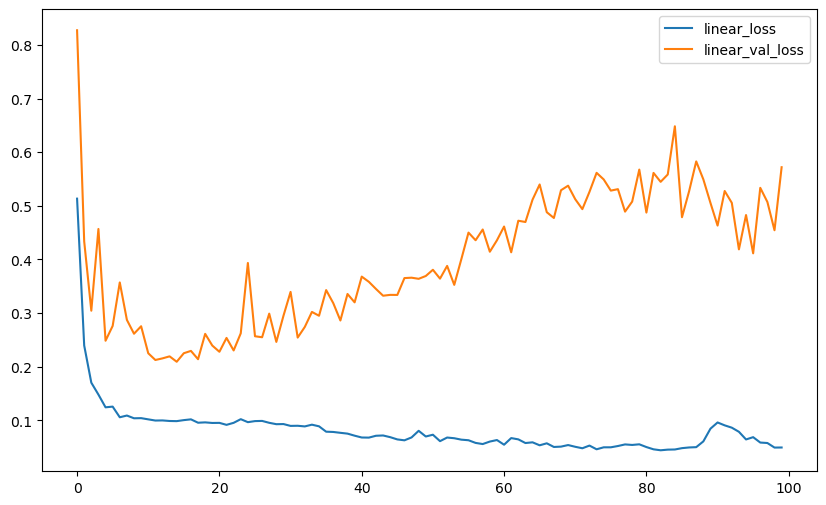

In [11]:
plt.figure(figsize=(10,6))
plt.plot(lstm_result.history['loss'], label='linear_loss')
plt.plot(lstm_result.history['val_loss'], label='linear_val_loss')
plt.legend()
plt.show()

8/8 [==============================] - 0s 647us/step
(235, 1)


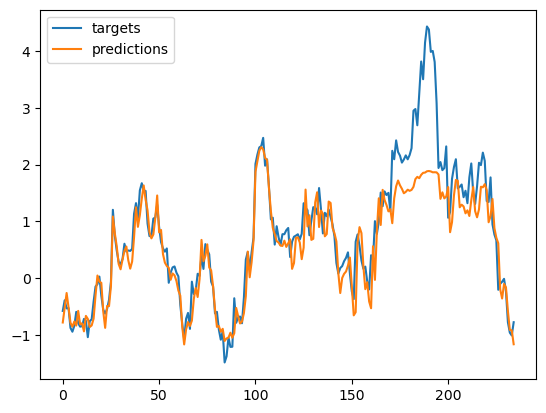

In [12]:
# 1-step forecast (wrong way to forecast by prediction just next value)
# 1-step forecast overfits, want to use multi-step forecast to utilize prediction to "see" into future
outputs = lstm_model.predict(X)
print(outputs.shape)
lstm_predictions = outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(lstm_predictions, label='predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 6ms/step


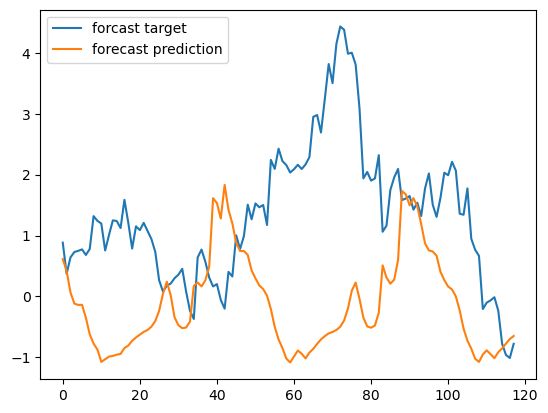

In [13]:
# Multi-step forecast
validation_target = Y[-N//2:]
lstm_validation_predictions = []

prev_x = X[-N//2] # array of first validation X eg: X[50:59]

while len(lstm_validation_predictions) < len(validation_target):
    p = lstm_model.predict(prev_x.reshape(1, T, 1))[0, 0]
    
    lstm_validation_predictions.append(p)
    
    # shift prev_x arr leftwards & append newest prediction
    prev_x = np.roll(prev_x, -1)
    prev_x[-1] = p

plt.plot(validation_target, label='forcast target')
plt.plot(lstm_validation_predictions, label='forecast prediction')
plt.legend()

#### Understanding of predictions

- model is not really predicting next value when using multi-step forecasting
- it is just copying the previous value

#### Unconventional to predict stock price

- easier to predict is the stock return
- Return = (Vfinal - Vinitial) / Vinitial


## Predicting Stock Returns


<Axes: >

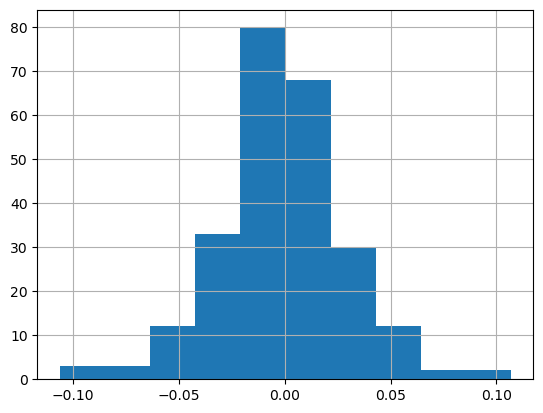

In [14]:
df['Change %'].hist()

In [15]:
series = df['Change %'].values[1:].reshape(-1, 1) # take 2nd value cuz 1st value is NaN

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [16]:
# Build dataset

T = 10
D = 1 # price
X = []
Y = []

# Get sliding window of x data [0:9], [1, 10] ... [N-T-1, N-1]
for t in range(len(series) - T):
    x = series[t: t+T]
    y = series[t + T]
    
    X.append(x)
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print(f"X.shape: {X.shape} | Y.shape: {Y.shape}")

X.shape: (234, 10, 1) | Y.shape: (234,)


In [17]:
M = 5 # No. hidden units
K = 1 # No, output units (1 for price)

input = Input(shape=(T, 1))
x = LSTM(M)(input)
x = Dense(K)(x)

lstm_return_model = Model(input, x)
lstm_return_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
)

lstm_return_result = lstm_return_model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=100,
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/100
4/4 [==============================] - 1s 48ms/step - loss: 1.0691 - val_loss: 1.1206
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0650 - val_loss: 1.0891
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0291 - val_loss: 1.1045
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0137 - val_loss: 1.0880
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0029 - val_loss: 1.0882
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0040 - val_loss: 1.0898
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0069 - val_loss: 1.0921
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0082 - val_loss: 1.0955
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0007 - val_loss: 1.0997
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0023 - val_loss: 1.1057
Epoch 11/100
4/4 [==========

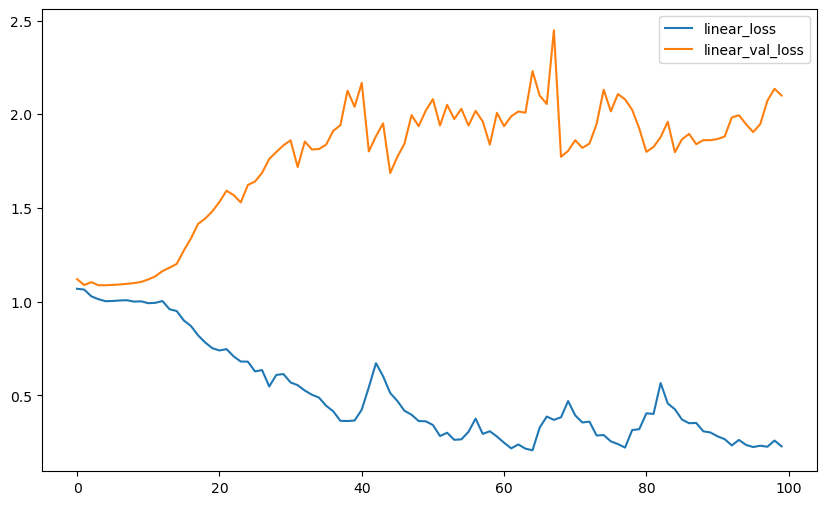

In [18]:
plt.figure(figsize=(10,6))
plt.plot(lstm_return_result.history['loss'], label='linear_loss')
plt.plot(lstm_return_result.history['val_loss'], label='linear_val_loss')
plt.legend()
plt.show()

8/8 [==============================] - 0s 687us/step
(234, 1)


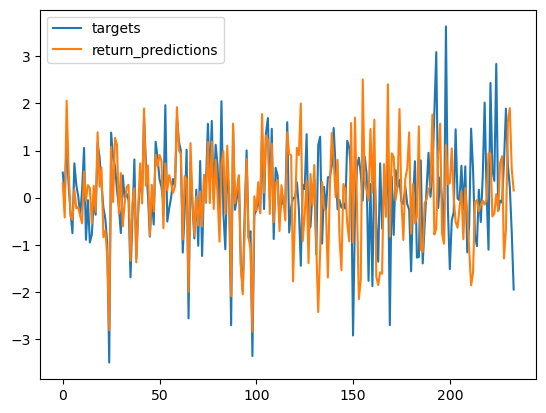

In [19]:
# 1-step forecast (wrong way to forecast by prediction just next value)
# 1-step forecast overfits, want to use multi-step forecast to utilize prediction to "see" into future
return_outputs = lstm_return_model.predict(X)
print(return_outputs.shape)
lstm_return_predictions = return_outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(lstm_return_predictions, label='return_predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 7ms/step


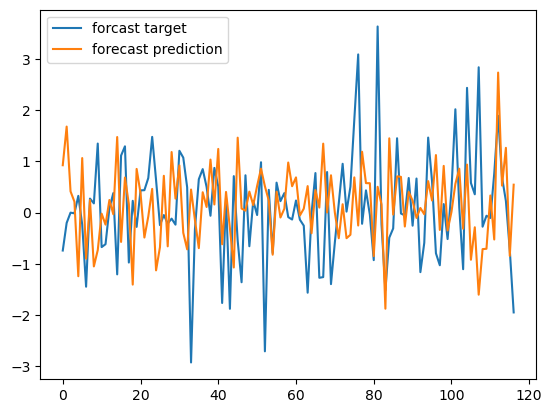

In [20]:
# Multi-step forecast
validation_target = Y[-N//2:]
lstm_return_validation_predictions = []

prev_x = X[-N//2] # array of first validation X eg: X[50:59]

while len(lstm_return_validation_predictions) < len(validation_target):
    p = lstm_return_model.predict(prev_x.reshape(1, T, 1))[0, 0]
    
    lstm_return_validation_predictions.append(p)
    
    # shift prev_x arr leftwards & append newest prediction
    prev_x = np.roll(prev_x, -1)
    prev_x[-1] = p

plt.plot(validation_target, label='forcast target')
plt.plot(lstm_return_validation_predictions, label='forecast prediction')
plt.legend()

### Model is still unable to pickup pattern & perform any form of forecasting for multi-step forecasting

- model is just copying value over and over again


### Last Model Exploration

- utilize OHLC + Volume data
- predict whether price will go up or down the next day (commonly done in Finance)
- regression is typically harder than classification


In [49]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-12-19,118.88,122.16,123.38,118.45,46160000.0,-0.0208
1,2024-12-18,121.41,125.43,127.75,120.43,49720000.0,-0.0289
2,2024-12-17,125.02,124.45,127.08,123.15,43310000.0,-0.0132
3,2024-12-16,126.69,126.01,127.76,123.12,42090000.0,-0.0017
4,2024-12-13,126.91,131.30,131.30,124.77,67540000.0,-0.0283


In [50]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [66]:
input_data = df.select_dtypes(include=['number']).drop(columns=['Price']).values
targets = df['Change %'].values

T = 10
D = input_data.shape[1]
N = input_data.shape[0] - T # if T = 10 and u have 11 datapoints, only have 1 set of window data

In [67]:
# normalize inputs (important because volume is much higher than prices)

Ntrain = len(input_data) * 2 // 3 # 66% train, 33% test
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [69]:
# setup train data
X_train = np.zeros((Ntrain, T, D)) # N x T x D 
Y_train = np.zeros(Ntrain) # N

for t in range(Ntrain):
    X_train[t, :, :] = input_data[t: t+T]
    Y_train[t] = (targets[t + T] > 0) # boolean, True if positive returns

In [70]:
# setup test data
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
    # u counts from 0 to (N - Ntrain) - to manipulate X_test & Y_test
    # t counts from Ntrain to N - to manipulate 2nd half of input data
    t = u + Ntrain
    X_test[u, :, :] = input_data[t: t+T]
    Y_test[u] = (targets[t+T] > 0)
    

In [71]:
M = 50 # No. of hidden units
K = 1 # No. of output nodes - 1 for true or false

input = Input(shape=(T, D))
x = LSTM(M)(input)
x = Dense(K, activation='sigmoid')(x)

model = Model(input, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [72]:
result = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_test, Y_test)
)

Epoch 1/300
6/6 [==============================] - 1s 55ms/step - loss: 0.6906 - accuracy: 0.4969 - val_loss: 0.7230 - val_accuracy: 0.4722
Epoch 2/300
6/6 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5276 - val_loss: 0.7372 - val_accuracy: 0.4861
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5337 - val_loss: 0.7399 - val_accuracy: 0.4861
Epoch 4/300
6/6 [==============================] - 0s 4ms/step - loss: 0.6824 - accuracy: 0.5399 - val_loss: 0.7341 - val_accuracy: 0.4861
Epoch 5/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.5460 - val_loss: 0.7297 - val_accuracy: 0.4861
Epoch 6/300
6/6 [==============================] - 0s 4ms/step - loss: 0.6793 - accuracy: 0.5521 - val_loss: 0.7285 - val_accuracy: 0.4861
Epoch 7/300
6/6 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5767 - val_loss: 0.7301 - val_accuracy: 0.4861
Epoch 8/300
6/6 [=========

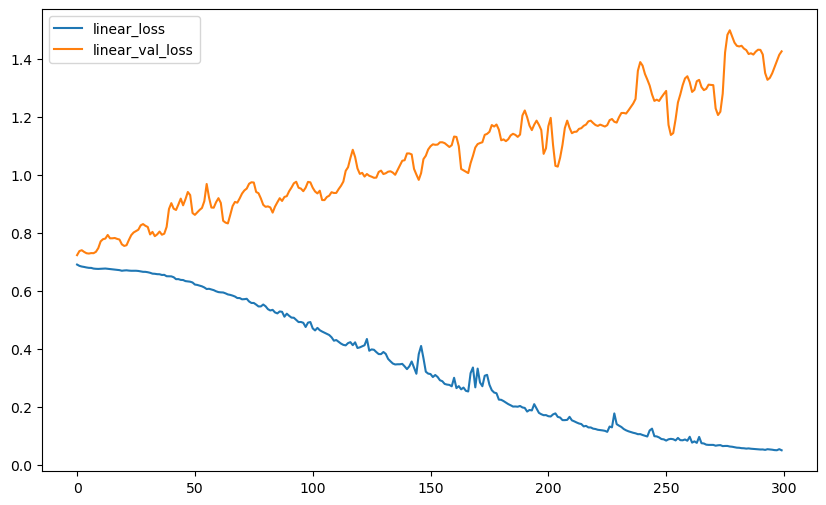

In [73]:
plt.figure(figsize=(10,6))
plt.plot(result.history['loss'], label='linear_loss')
plt.plot(result.history['val_loss'], label='linear_val_loss')
plt.legend()
plt.show()

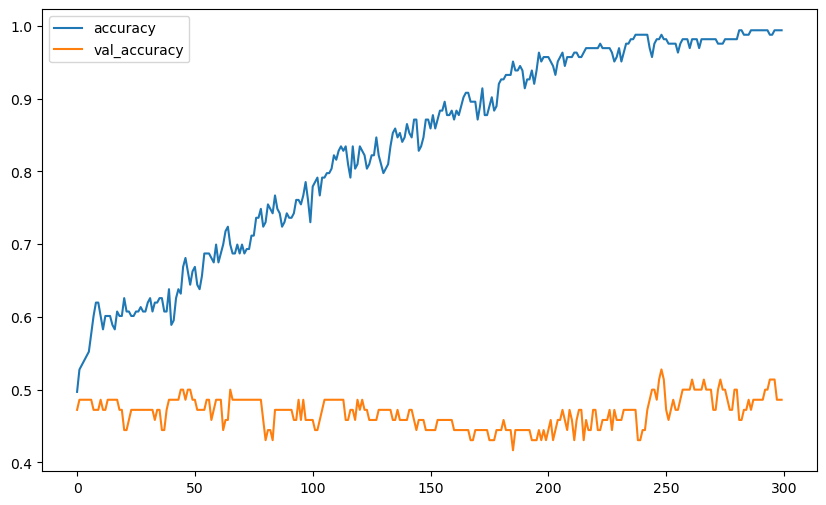

In [75]:
plt.figure(figsize=(10,6))
plt.plot(result.history['accuracy'], label='accuracy')
plt.plot(result.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

### Binary Accuracy

    - 0% accuracy is not the worst - because its just predicting everything in the reverse (i.e the model is actually very accurate)
    - 50% accuracy is the worst type of accuracy in binary classification (no better than random guesses)

##### Even with simplest task with the most data, model doesn't do better than random guessing

- predicting stock market price and trends will be even more impossible
- if we can't even predict with accuracy whether stock price will go up or down, its impossible to predict actual return value

##### Be suspicious when theres an almost-perfect stock price forecast

##### its not even possible to predict a noisy sine wave, which by itself is semi-deterministic

- then its not possible to predict stock prices, which is non-deterministic

##### LSTMs will be more practical in language modelling
